In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setup & Load Metadata**



In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


# Paths
EXCEL_PATH = "/content/drive/MyDrive/EEE385L/correctSheetlast.xlsx"
IMG_DIR = "/content/drive/MyDrive/EEE385L/mammograms"

# Load required columns only
cols_needed = ['Assesment', 'Image path']
df = pd.read_excel(EXCEL_PATH, usecols=cols_needed)

# Clean column names and values
df.columns = df.columns.str.strip()
df['Assesment'] = df['Assesment'].astype(str).str.strip().str.upper()
df['Image path'] = df['Image path'].astype(str).str.strip()

# Verify
print(" Metadata preview")
print(df.head())
print("\nUnique BI-RADS in 'Assesment':", df['Assesment'].unique())



 Metadata preview
  Assesment                        Image path
0   BIRAD 2   BIRAD 2/2019_BC007741_ CC_R.dcm
1   BIRAD 2  BIRAD 2/2019_BC007741_ MLO_R.dcm
2   BIRAD 2   BIRAD 2/2019_BC007741_ CC_L.dcm
3   BIRAD 2  BIRAD 2/2019_BC007741_ MLO_L.dcm
4   BIRAD 2   BIRAD 2/2019_BC005401_ CC_R.dcm

Unique BI-RADS in 'Assesment': ['BIRAD 2' 'BIRAD 3' 'BIRAD 1' 'BIRAD 4' 'BIRAD 5' 'NAN']


In [3]:
import pandas as pd

EXCEL_PATH = "/content/drive/MyDrive/EEE385L/correctSheetlast.xlsx"

# Load full Excel file (no usecols restriction)
raw_df = pd.read_excel(EXCEL_PATH)

# Show original column names
print("Original columns from Excel:")
print(list(raw_df.columns))


Original columns from Excel:
['Study date', 'PatientID', 'Patient age ', 'Breast  type', 'Breast view', 'Percentage of\n grandular tissue(density)', 'Assesment', 'Image path']


In [4]:
# Strip spaces and newlines from column names
raw_df.columns = raw_df.columns.str.strip().str.replace('\n', ' ', regex=True)

# Just keep relevant columns
cols_needed = ['Assesment', 'Image path']
df = raw_df[cols_needed].copy()

# Clean values inside the selected columns
df['Assesment'] = df['Assesment'].astype(str).str.strip().str.upper()
df['Image path'] = df['Image path'].astype(str).str.strip()

# Verify
print(" Cleaned Metadata Preview:")
print(df.head())
print("\nUnique BI-RADS in 'Assesment':", df['Assesment'].unique())


 Cleaned Metadata Preview:
  Assesment                        Image path
0   BIRAD 2   BIRAD 2/2019_BC007741_ CC_R.dcm
1   BIRAD 2  BIRAD 2/2019_BC007741_ MLO_R.dcm
2   BIRAD 2   BIRAD 2/2019_BC007741_ CC_L.dcm
3   BIRAD 2  BIRAD 2/2019_BC007741_ MLO_L.dcm
4   BIRAD 2   BIRAD 2/2019_BC005401_ CC_R.dcm

Unique BI-RADS in 'Assesment': ['BIRAD 2' 'BIRAD 3' 'BIRAD 1' 'BIRAD 4' 'BIRAD 5' 'NAN']


# **Extract BI-RADS Labels & Filter**

In [5]:
# Extract numeric BI-RADS value
df['BI-RADS_num'] = df['Assesment'].str.extract(r'(\d)').astype(float)

# Filter to keep only BIRADS 1,3,4,5 (drop 2)
valid_birads = [1, 3, 4, 5]
df = df[df['BI-RADS_num'].isin(valid_birads)].copy()

# Map to class labels
label_map = {1: 0, 3: 1, 4: 2, 5: 3}
df['label'] = df['BI-RADS_num'].map(label_map)

# Verify
print("Label distribution")
print(df['label'].value_counts())


Label distribution
label
0    1884
1     290
2      72
3      22
Name: count, dtype: int64


# **Construct Valid Image Paths (.jpg) and Filter**

In [6]:
import glob

# Check for any JPGs
found_files = glob.glob('/content/drive/MyDrive/EEE385L/mammograms/**/*.jpg', recursive=True)
print(f" Total JPGs found: {len(found_files)}")
print(found_files[:5])  # Show a few


 Total JPGs found: 2378
['/content/drive/MyDrive/EEE385L/mammograms/BIRAD 1/2016_BC017021_ MLO_R.jpg', '/content/drive/MyDrive/EEE385L/mammograms/BIRAD 1/2017_BC003381_ CC_R.jpg', '/content/drive/MyDrive/EEE385L/mammograms/BIRAD 1/2017_BC015881_ CC_L.jpg', '/content/drive/MyDrive/EEE385L/mammograms/BIRAD 1/2016_BC016243_ MLO_R.jpg', '/content/drive/MyDrive/EEE385L/mammograms/BIRAD 1/2017_BC0020541_ CC_R.jpg']


In [7]:
# Show actual column names from Excel
print("Original columns:", df.columns.tolist())

# Clean column names
df.columns = df.columns.str.strip()

# Re-check after stripping
print("Cleaned columns:", df.columns.tolist())


Original columns: ['Assesment', 'Image path', 'BI-RADS_num', 'label']
Cleaned columns: ['Assesment', 'Image path', 'BI-RADS_num', 'label']


In [8]:
# Use the correct column name after cleaning
df['Image path'] = df['Image path'].astype(str).str.strip().str.replace('.dcm', '.jpg')


In [9]:
import os

# Update paths to .jpg and construct full paths
df['Image path'] = df['Image path'].astype(str).str.strip().str.replace('.dcm', '.jpg')
df['image_full_path'] = df['Image path'].apply(lambda p: os.path.join(IMG_DIR, p))

# Keep only valid paths (file exists)
df = df[df['image_full_path'].apply(os.path.exists)].copy()

print(f"Total valid images found: {len(df)}")
df[['label', 'image_full_path']].head()


Total valid images found: 2206


,label,image_full_path
16,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
21,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
22,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
23,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
24,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...


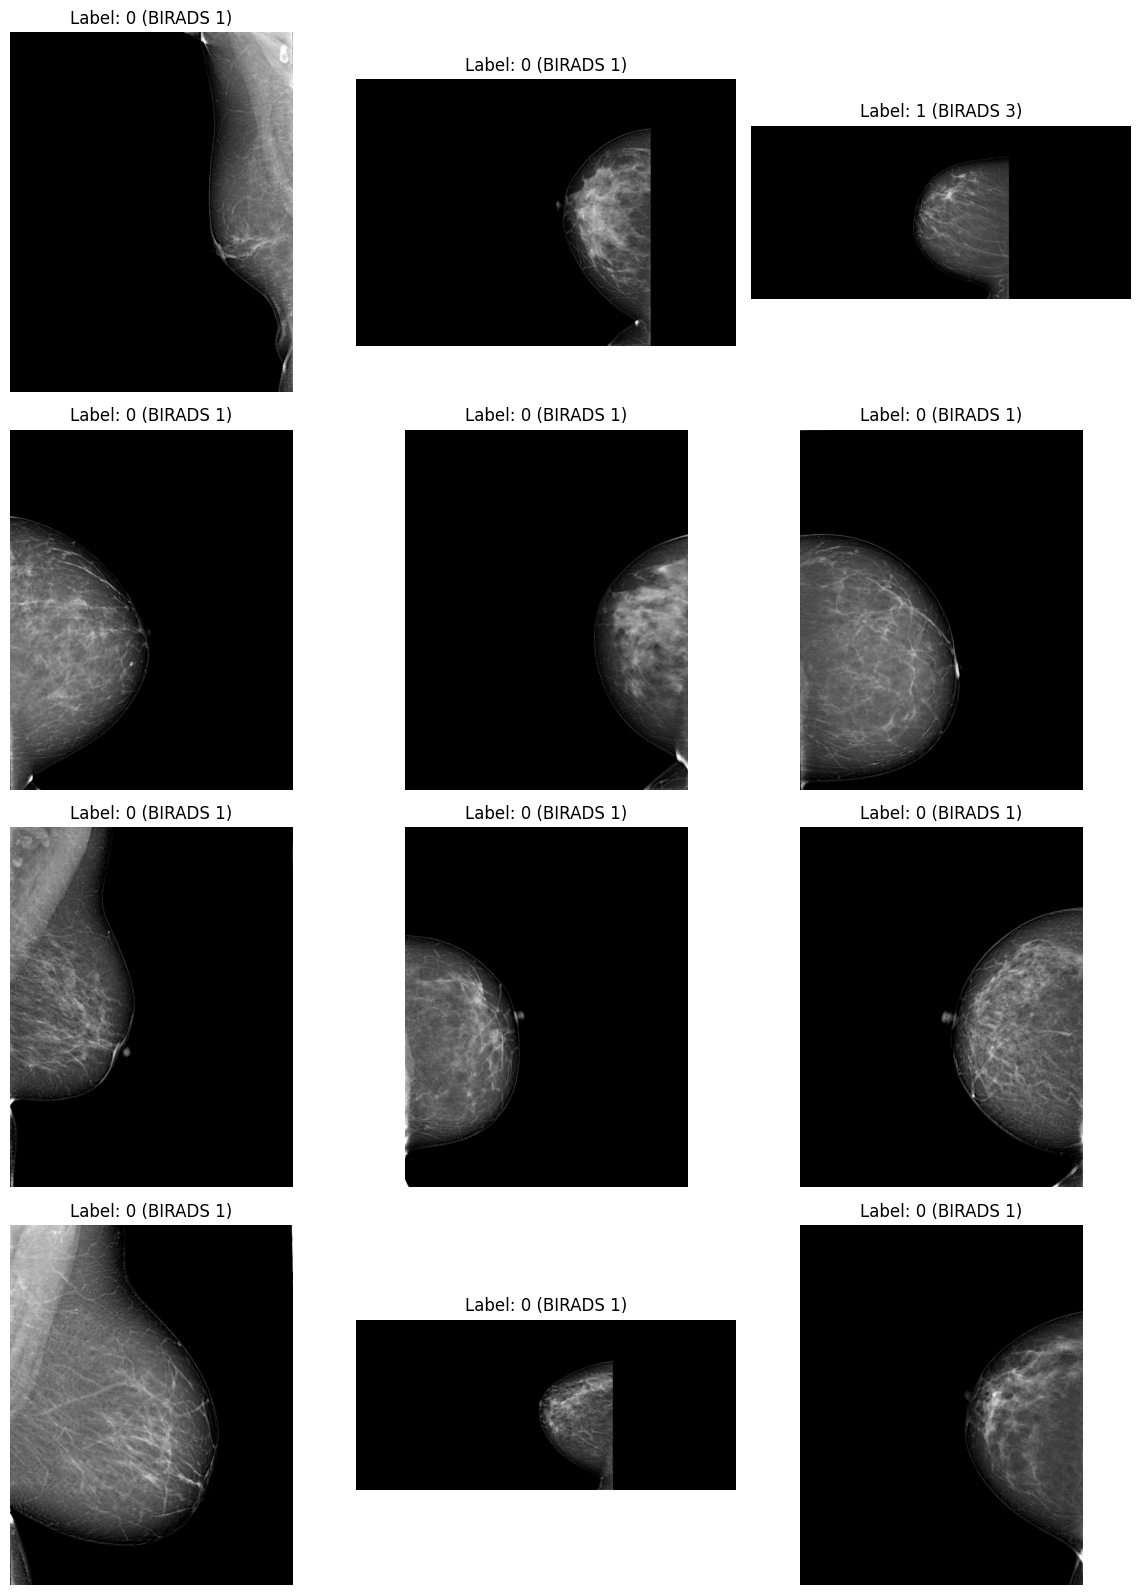

In [10]:
import matplotlib.pyplot as plt
import cv2
import random

# Show 6 random samples
samples = df.sample(n=12, random_state=50)  # Random sampling

plt.figure(figsize=(12, 24))
for i, row in enumerate(samples.iterrows()):
    img = cv2.imread(row[1]['image_full_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(6, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {row[1]['label']} (BIRADS {list(label_map.keys())[list(label_map.values()).index(row[1]['label'])]})")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
# Check for the presence of label 1 (BI-RADS 3)
print("Label counts:\n", df['label'].value_counts())

# Optional: filter rows where label == 1
birads_3_samples = df[df['label'] == 1]
print(f"\n Total BI-RADS 3 (label 1) samples: {len(birads_3_samples)}")
print(birads_3_samples.head())


Label counts:
 label
0    1847
1     265
2      72
3      22
Name: count, dtype: int64

 Total BI-RADS 3 (label 1) samples: 265
   Assesment                         Image path  BI-RADS_num  label  \
16   BIRAD 3  BIRAD 3/2019_BC0022845_ MLO_L.jpg          3.0      1   
21   BIRAD 3   BIRAD 3/2019_BC0026061_ CC_R.jpg          3.0      1   
22   BIRAD 3  BIRAD 3/2019_BC0026061_ MLO_R.jpg          3.0      1   
23   BIRAD 3   BIRAD 3/2019_BC0026061_ CC_L.jpg          3.0      1   
24   BIRAD 3  BIRAD 3/2019_BC0026061_ MLO_L.jpg          3.0      1   

                                      image_full_path  
16  /content/drive/MyDrive/EEE385L/mammograms/BIRA...  
21  /content/drive/MyDrive/EEE385L/mammograms/BIRA...  
22  /content/drive/MyDrive/EEE385L/mammograms/BIRA...  
23  /content/drive/MyDrive/EEE385L/mammograms/BIRA...  
24  /content/drive/MyDrive/EEE385L/mammograms/BIRA...  


# **TensorFlow Dataset & Train/Val Split**

In [38]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Config ---
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Split into train and validation sets ---
from sklearn.model_selection import train_test_split

# First split: train (75%) and temp (25%)
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)

# Second split: validation (15%) and test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.4, stratify=temp_df['label'], random_state=42)

print(f" Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


# --- Class weights to handle imbalance ---
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))
print(f" Class weights: {class_weights}")


 Train: 1654, Val: 331, Test: 221
 Class weights: {0: np.float64(0.2985559566787004), 1: np.float64(2.077889447236181), 2: np.float64(7.657407407407407), 3: np.float64(25.84375)}


In [39]:
import cv2

# --- Define image loading and preprocessing ---
def load_image(path, label):
    path = path.numpy().decode()
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # normalize to [0,1]
    return image.astype(np.float32), np.int32(label)

def tf_wrap_load_image(path, label):
    img, lbl = tf.py_function(func=load_image, inp=[path, label], Tout=(tf.float32, tf.int32))
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    lbl.set_shape([])
    return img, lbl


In [40]:
def create_dataset(dataframe, augment=False, shuffle=True):
    paths = dataframe['image_full_path'].values
    labels = dataframe['label'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(tf_wrap_load_image, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Create datasets
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df, shuffle=False)


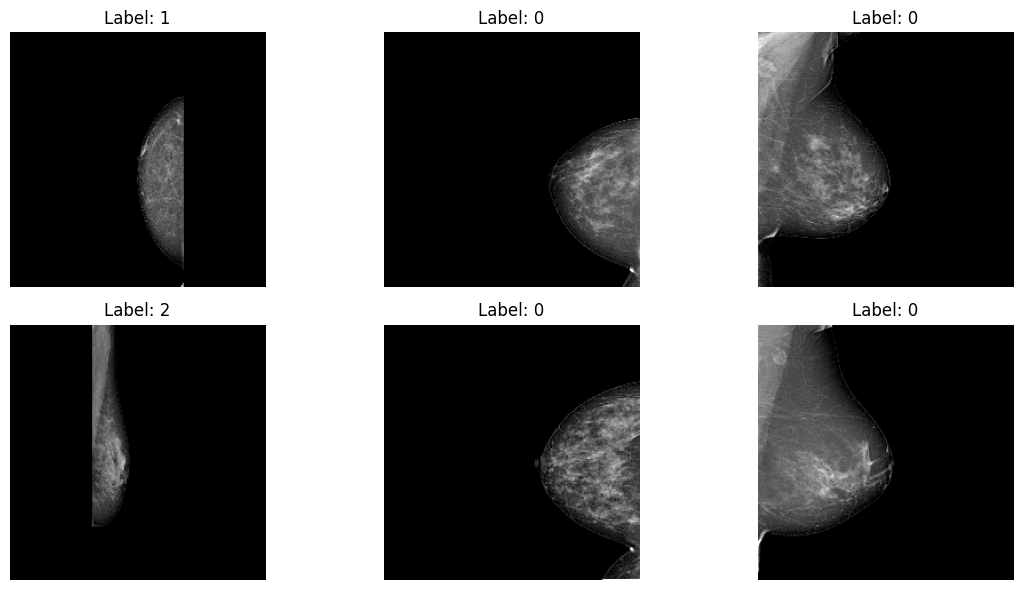

In [41]:
import matplotlib.pyplot as plt

# Visualize a batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


#  Define & Train CNN Model

In [43]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# --- Define CNN model ---
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])


In [44]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [45]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,596 (84.86 MB)

 Trainable params: 22,246,148 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [46]:
# Get a single batch
for images, labels in train_ds.take(1):
    preds = model(images)
    print("Predictions shape:", preds.shape)
    break


Predictions shape: (32, 4)


In [47]:
class_weight=class_weights
print(class_weights)


{0: np.float64(0.2985559566787004), 1: np.float64(2.077889447236181), 2: np.float64(7.657407407407407), 3: np.float64(25.84375)}


In [48]:
for _, labels in train_ds.take(1):
    print("Sample labels dtype:", labels.dtype)
    print("Sample labels:", labels.numpy())
    break


Sample labels dtype: <dtype: 'int32'>
Sample labels: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0]


In [23]:
#  Define CNN Baseline
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')  # 4 BI-RADS classes
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.7346 - loss: 1.2776 - val_accuracy: 0.5378 - val_loss: 1.3770
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.4564 - loss: 1.2326 - val_accuracy: 0.5136 - val_loss: 1.1090
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 332s 5s/step - accuracy: 0.3848 - loss: 0.9655 - val_accuracy: 0.4864 - val_loss: 1.1219
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.4659 - loss: 0.9571 - val_accuracy: 0.4441 - val_loss: 1.1887
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.4796 - loss: 0.9261 - val_accuracy: 0.4622 - val_loss: 1.0899
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.4743 - loss: 0.8443 - val_accuracy: 0.3746 - val_loss: 1.1981
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.4597 - loss: 0.8490 - val_accuracy: 0.3958 - val_loss: 1.2101
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.4845 - loss: 0.8995 - val_accuracy: 0.4139 - v

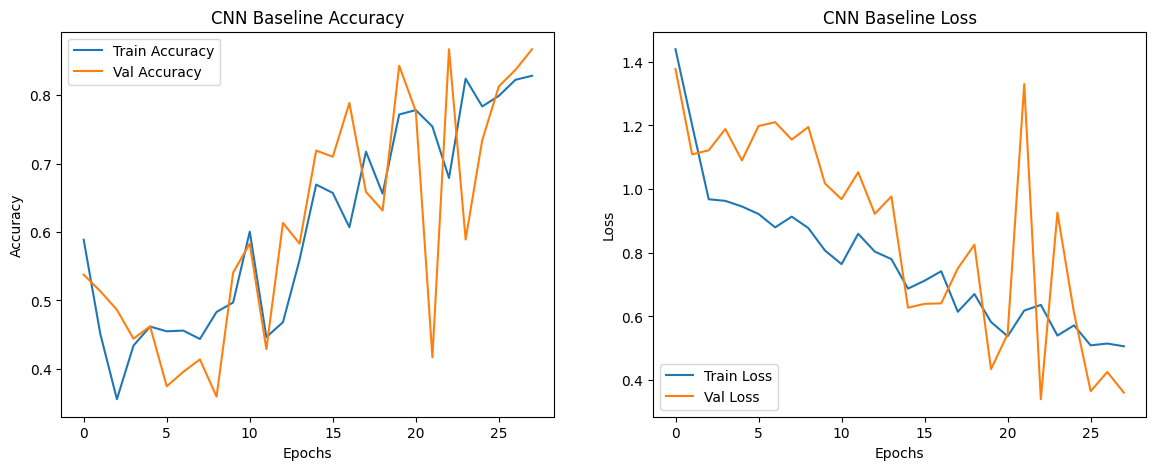

In [33]:
def plot_training_history(history, model_name="CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(cnn_history, model_name="CNN Baseline")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step

 CNN Baseline - Classification Report
              precision    recall  f1-score   support

   BI-RADS 1       0.98      0.91      0.94       277
           3       0.51      0.78      0.61        40
           4       0.22      0.18      0.20        11
           5       0.50      0.33      0.40         3

    accuracy                           0.87       331
   macro avg       0.55      0.55      0.54       331
weighted avg       0.89      0.87      0.87       331



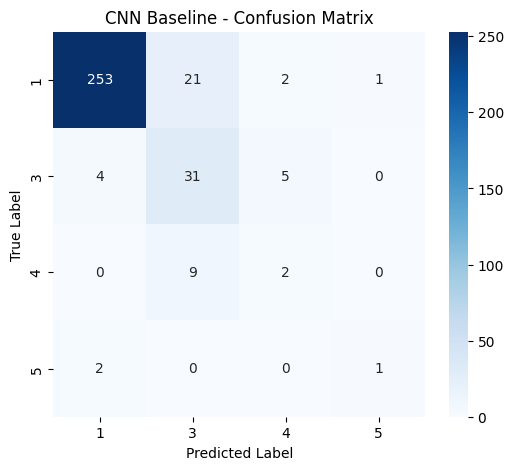

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, val_ds, name="Model"):
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {name} - Classification Report")
    print(classification_report(y_true, y_pred, target_names=["BI-RADS 1", "3", "4", "5"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["1", "3", "4", "5"],
                yticklabels=["1", "3", "4", "5"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate CNN
evaluate_model(cnn_model, val_ds, name="CNN Baseline")


Total misclassifications: 70


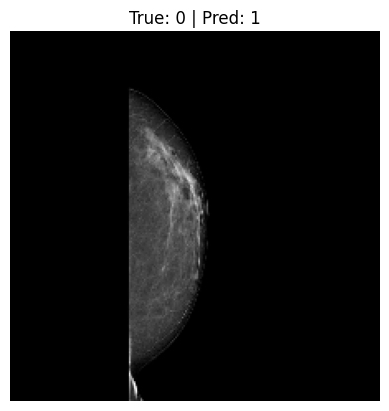

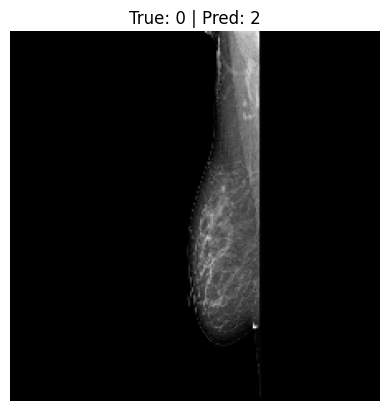

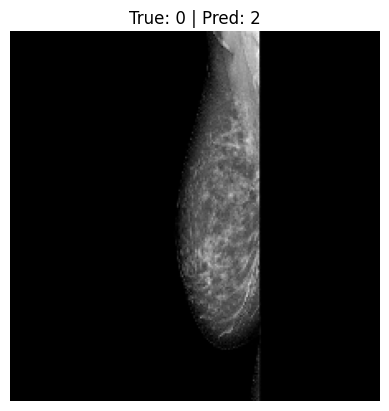

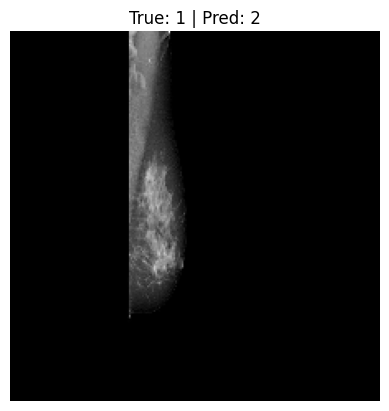

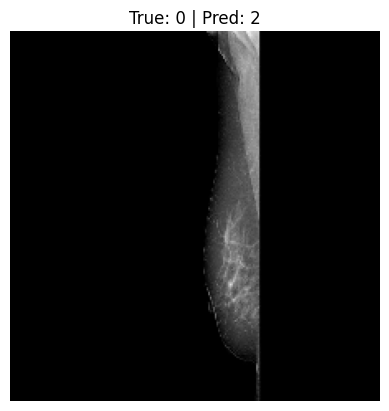

In [68]:
# Misclassified samples
misclassified = [(i, t, p) for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print(f"Total misclassifications: {len(misclassified)}")

# Visualize a few
import matplotlib.pyplot as plt

indices = [i for i, _, _ in misclassified[:5]]
samples = [val_ds.unbatch().skip(i).take(1) for i in indices]

for i, sample in enumerate(samples):
    for img, label in sample:
        plt.imshow(img.numpy())
        plt.title(f"True: {label.numpy()} | Pred: {y_pred[indices[i]]}")
        plt.axis('off')
        plt.show()


In [51]:
# Confirm label mapping and distribution
print("Unique labels:", sorted(df['label'].unique()))
print(df['label'].value_counts())

# Preview some image paths and corresponding labels
df[['label', 'image_full_path']].sample(10)


Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
label
0    1847
1     265
2      72
3      22
Name: count, dtype: int64


,label,image_full_path
5191,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
4995,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
262,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
1952,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
3040,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
1972,1,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
4082,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
4952,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
271,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...
5292,0,/content/drive/MyDrive/EEE385L/mammograms/BIRA...


In [52]:
# Check output confidence from the model
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    print("Sample predictions (softmax probs):\n", preds[:5])
    print("Predicted class:", np.argmax(preds[:5], axis=1))
    print("True class:     ", labels[:5].numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sample predictions (softmax probs):
 [[0.2506866  0.24972722 0.23617229 0.26341388]
 [0.25066352 0.25195003 0.24364315 0.2537433 ]
 [0.251902   0.24804318 0.23726971 0.26278505]
 [0.25884008 0.2503911  0.23727995 0.25348884]
 [0.23343952 0.24463029 0.24691784 0.27501234]]
Predicted class: [3 3 3 0 3]
True class:      [0 0 0 0 0]


# Advanced Model: MobileNetV2

In [59]:
from tensorflow.keras import layers, models, applications



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
base_mobile = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_mobile.trainable = False

mobile_model = models.Sequential([
    base_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

mobile_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Train
mobile_history = mobile_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.4445 - loss: 1.6284 - val_accuracy: 0.7583 - val_loss: 0.5127
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7611 - loss: 0.7774 - val_accuracy: 0.8218 - val_loss: 0.4425
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7722 - loss: 0.5404 - val_accuracy: 0.8218 - val_loss: 0.5217
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7946 - loss: 0.5295 - val_accuracy: 0.7644 - val_loss: 0.5729
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6346 - loss: 0.6562 - val_accuracy: 0.7825 - val_loss: 0.4888
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8107 - loss: 0.4662 - val_accuracy: 0.8066 - val_loss: 0.3956
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8266 - loss: 0.4310 - val_accuracy: 0.7885 - val_loss: 0.3764
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8244 - loss: 0.4497 - val_accuracy: 0.7976 - v

# Metrics & Classification

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=["BIRADS 1", "3", "4", "5"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

    BIRADS 1       1.00      0.03      0.05       277
           3       0.18      0.41      0.25        39
           4       0.02      0.36      0.03        11
           5       0.00      0.00      0.00         4

    accuracy                           0.08       331
   macro avg       0.30      0.20      0.08       331
weighted avg       0.86      0.08      0.07       331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Total misclassifications: 304


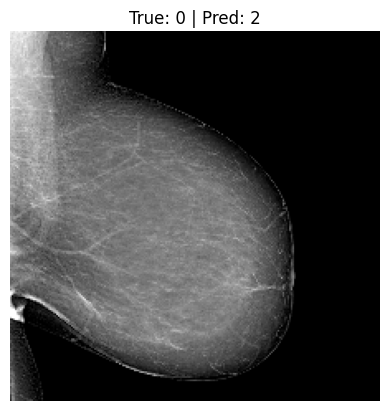

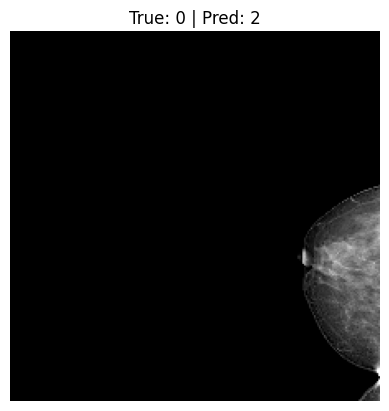

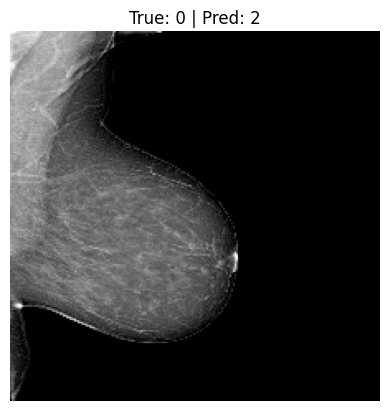

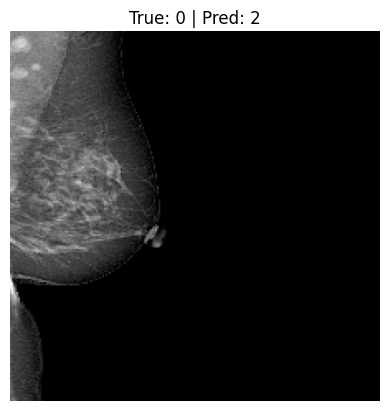

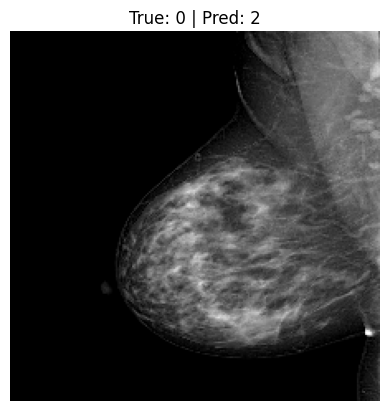

In [63]:
# Misclassified samples
misclassified = [(i, t, p) for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print(f"Total misclassifications: {len(misclassified)}")

# Visualize a few
import matplotlib.pyplot as plt

indices = [i for i, _, _ in misclassified[:5]]
samples = [val_ds.unbatch().skip(i).take(1) for i in indices]

for i, sample in enumerate(samples):
    for img, label in sample:
        plt.imshow(img.numpy())
        plt.title(f"True: {label.numpy()} | Pred: {y_pred[indices[i]]}")
        plt.axis('off')
        plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7795 - loss: 0.3835

 Validation Accuracy: 0.7885 | Loss: 0.3764
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

 Classification Report:
              precision    recall  f1-score   support

   BI-RADS 1       1.00      0.86      0.92       277
   BI-RADS 3       0.53      0.21      0.30        39
   BI-RADS 4       0.14      0.91      0.24        11
   BI-RADS 5       0.80      1.00      0.89         4

    accuracy                           0.79       331
   macro avg       0.62      0.74      0.59       331
weighted avg       0.91      0.79      0.83       331



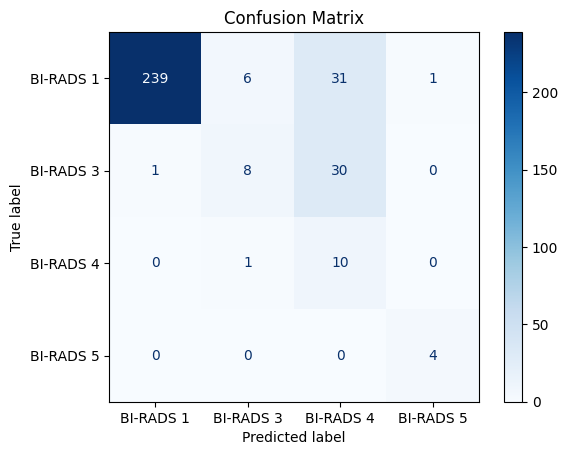

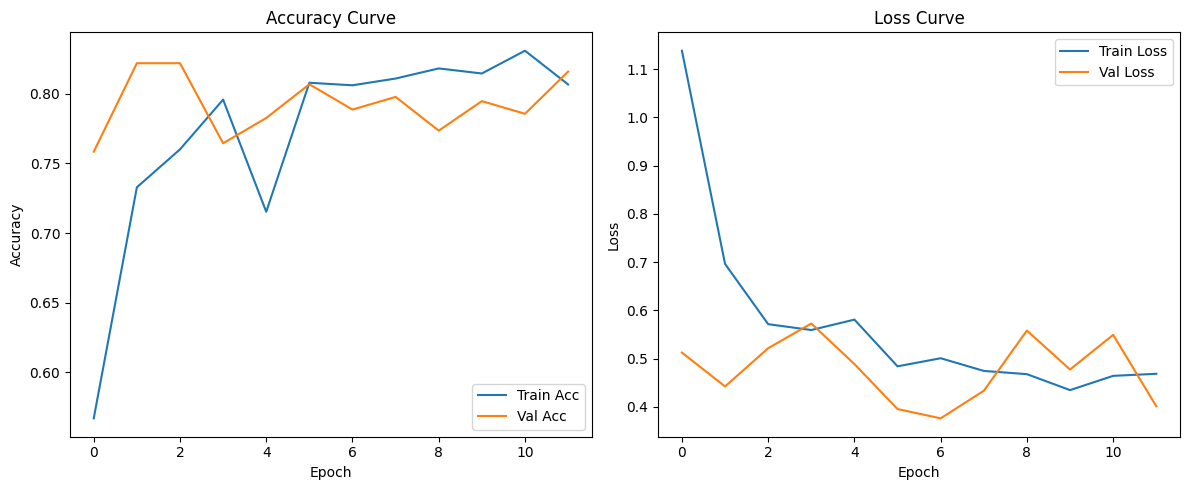

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate on validation set
val_loss, val_acc = mobile_model.evaluate(val_ds)
print(f"\n Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f}")

# Predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = mobile_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
target_names = ['BI-RADS 1', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5']
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Accuracy/Loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mobile_history.history['accuracy'], label="Train Acc")
plt.plot(mobile_history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobile_history.history['loss'], label="Train Loss")
plt.plot(mobile_history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# ResNet50 + Training + Evaluation

In [69]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix

#  Constants
IMG_SIZE = 224
NUM_CLASSES = 4

#  Model Definition (with pretrained ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Fine-tune later if needed

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [70]:
#  ResNet50 Feature Extractor
base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_resnet.trainable = False

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Train
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 477s 8s/step - accuracy: 0.3610 - loss: 1.6028 - val_accuracy: 0.0332 - val_loss: 1.7337
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 478s 8s/step - accuracy: 0.1763 - loss: 1.3765 - val_accuracy: 0.0332 - val_loss: 1.5940
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 494s 8s/step - accuracy: 0.1449 - loss: 1.3717 - val_accuracy: 0.1178 - val_loss: 1.3469
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.2307 - loss: 1.4765 - val_accuracy: 0.1178 - val_loss: 1.4063
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 444s 8s/step - accuracy: 0.1511 - loss: 1.4678 - val_accuracy: 0.1178 - val_loss: 1.4409
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 443s 8s/step - accuracy: 0.2755 - loss: 1.3097 - val_accuracy: 0.8308 - val_loss: 1.3077
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.2596 - loss: 1.3513 - val_accuracy: 0.0423 - val_loss: 1.3720
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.2884 - loss: 1.3834 - val_accuracy: 0.0906 - v

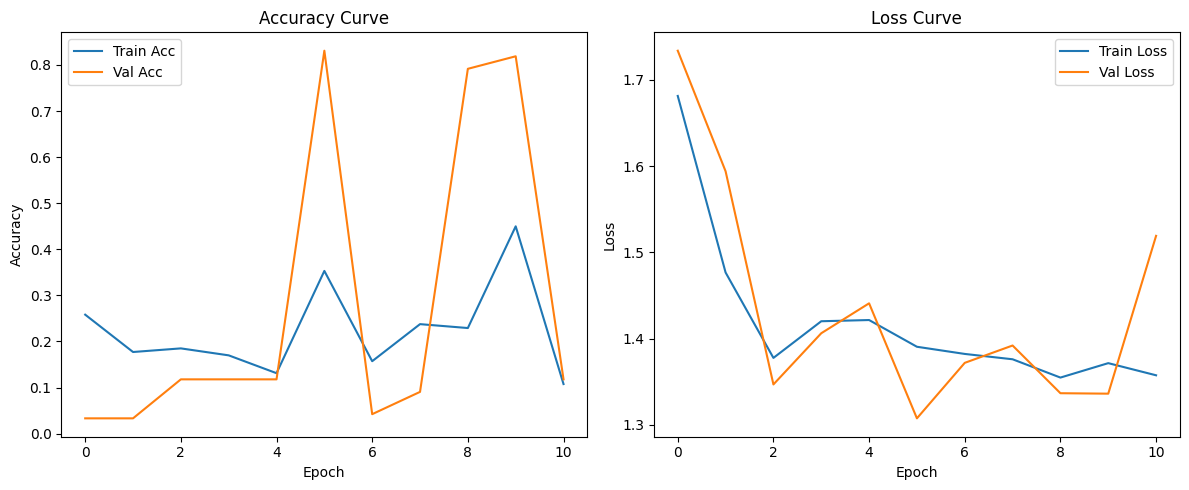

In [72]:
def plot_history(history):
    acc =resnet_history.history['accuracy']
    val_acc = resnet_history.history['val_accuracy']
    loss = resnet_history.history['loss']
    val_loss =resnet_history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(resnet_history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    BIRADS 1       0.84      0.98      0.91       277
           3       0.40      0.10      0.16        39
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         4

    accuracy                           0.83       331
   macro avg       0.31      0.27      0.27       331
weighted avg       0.75      0.83      0.78       331



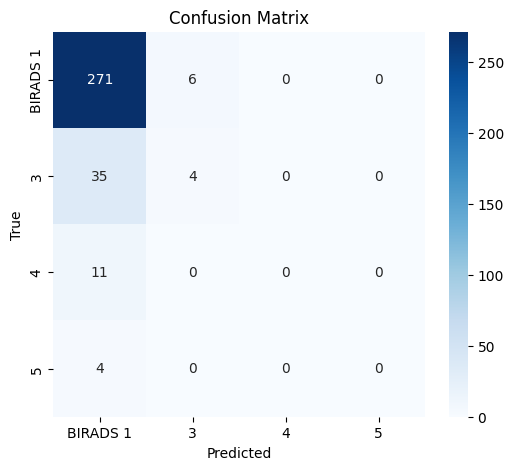

In [74]:
# Get true & predicted labels
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = resnet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=["BIRADS 1", "3", "4", "5"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["BIRADS 1", "3", "4", "5"],
            yticklabels=["BIRADS 1", "3", "4", "5"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Total misclassifications: 56


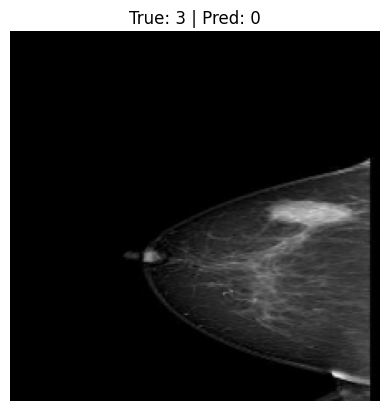

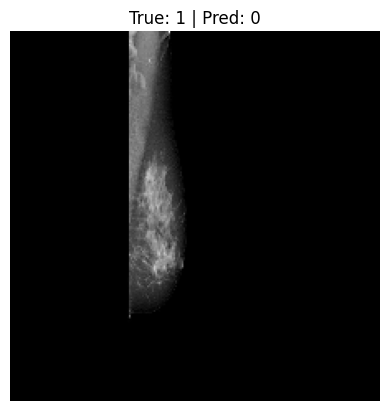

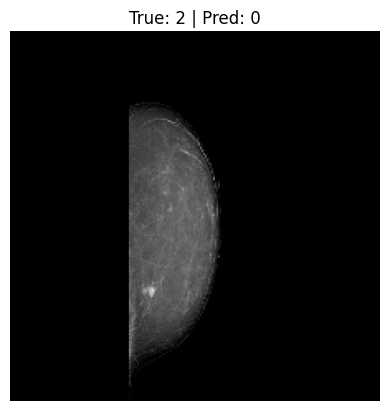

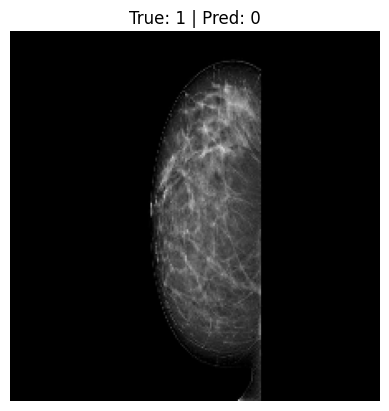

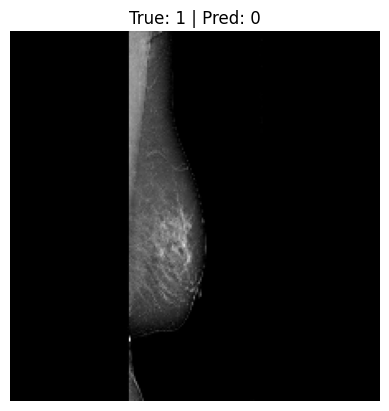

In [75]:
# Misclassified samples
misclassified = [(i, t, p) for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print(f"Total misclassifications: {len(misclassified)}")

# Visualize a few
import matplotlib.pyplot as plt

indices = [i for i, _, _ in misclassified[:5]]
samples = [val_ds.unbatch().skip(i).take(1) for i in indices]

for i, sample in enumerate(samples):
    for img, label in sample:
        plt.imshow(img.numpy())
        plt.title(f"True: {label.numpy()} | Pred: {y_pred[indices[i]]}")
        plt.axis('off')
        plt.show()


# EfficientNetB0 Model + Training Block

In [76]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_effnet = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_effnet.trainable = False

effnet_model = models.Sequential([
    base_effnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

effnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Train
effnet_history = effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.4386 - loss: 1.3472 - val_accuracy: 0.0121 - val_loss: 1.4917
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.1403 - loss: 1.2978 - val_accuracy: 0.0121 - val_loss: 1.4020
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.0942 - loss: 1.3769 - val_accuracy: 0.0332 - val_loss: 1.3822
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.1418 - loss: 1.4810 - val_accuracy: 0.0332 - val_loss: 1.2780
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.2025 - loss: 1.4057 - val_accuracy: 0.1178 - val_loss: 1.3887
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.2913 - loss: 1.2519 - val_accuracy: 0.0121 - val_loss: 1.4029
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.0075 - loss: 1.2323 - val_accuracy: 0.0121 - val_loss: 1.4012
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accurac

Classification Report
              precision    recall  f1-score   support

    BIRADS 1       0.00      0.00      0.00       277
           3       0.00      0.00      0.00        39
           4       0.03      1.00      0.06        11
           5       0.00      0.00      0.00         4

    accuracy                           0.03       331
   macro avg       0.01      0.25      0.02       331
weighted avg       0.00      0.03      0.00       331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


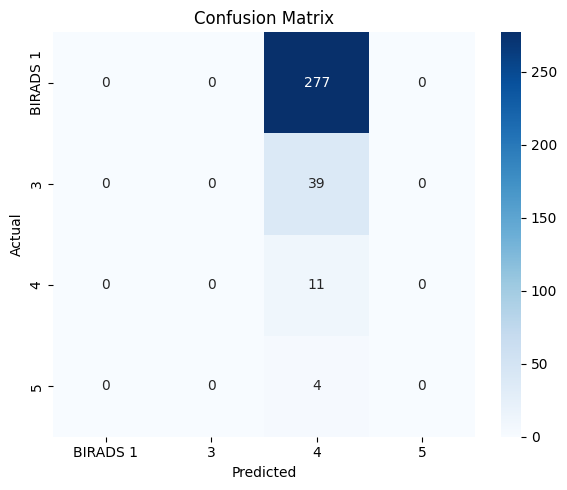

In [77]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true & predicted labels
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = effnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
class_names = ["BIRADS 1", "3", "4", "5"]
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

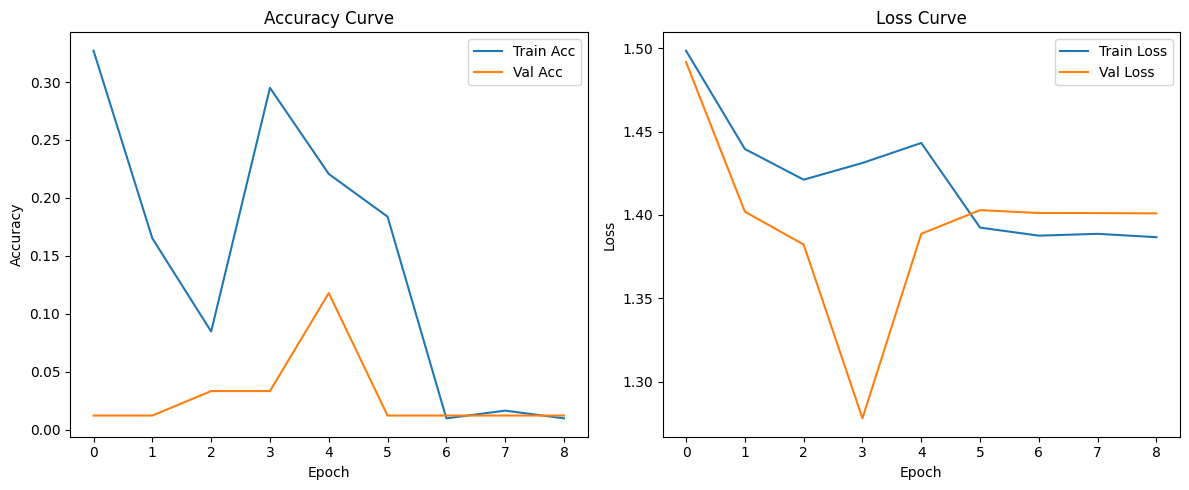

In [78]:
def plot_history(history):
    acc = effnet_history.history['accuracy']
    val_acc = effnet_history.history['val_accuracy']
    loss = effnet_history.history['loss']
    val_loss =effnet_history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(effnet_history)


Total misclassifications: 320


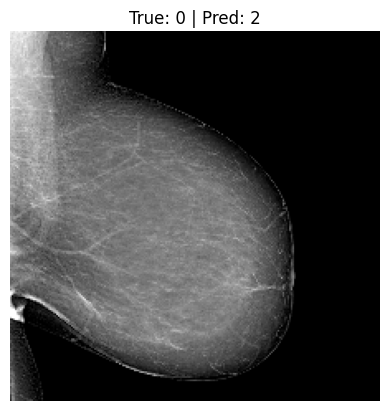

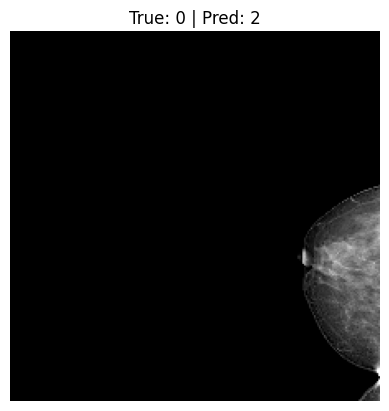

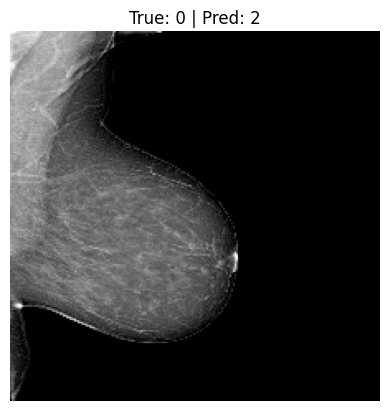

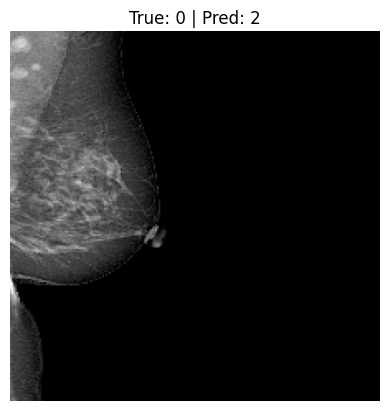

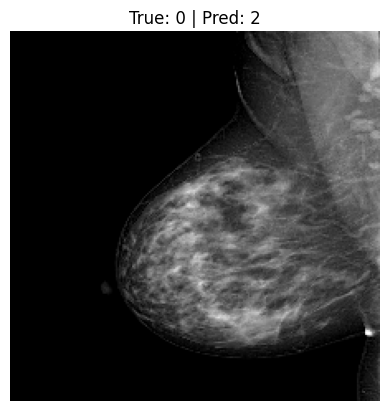

In [79]:
# Misclassified samples
misclassified = [(i, t, p) for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print(f"Total misclassifications: {len(misclassified)}")

# Visualize a few
import matplotlib.pyplot as plt

indices = [i for i, _, _ in misclassified[:5]]
samples = [val_ds.unbatch().skip(i).take(1) for i in indices]

for i, sample in enumerate(samples):
    for img, label in sample:
        plt.imshow(img.numpy())
        plt.title(f"True: {label.numpy()} | Pred: {y_pred[indices[i]]}")
        plt.axis('off')
        plt.show()


# Final Comparison

Evaluation + Metrics + Confusion Matrix + Grad-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step

 CNN Classification Report
              precision    recall  f1-score   support

    BIRADS 1       0.98      0.90      0.94       277
           3       0.48      0.74      0.58        39
           4       0.22      0.18      0.20        11
           5       0.60      0.75      0.67         4

    accuracy                           0.86       331
   macro avg       0.57      0.64      0.60       331
weighted avg       0.89      0.86      0.87       331



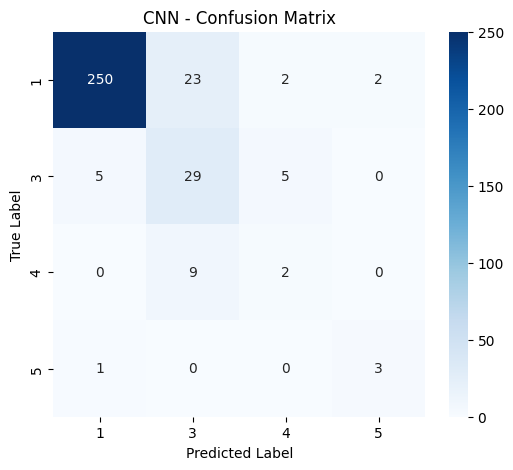

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

 ResNet50 Classification Report
              precision    recall  f1-score   support

    BIRADS 1       0.84      0.98      0.91       277
           3       0.40      0.10      0.16        39
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         4

    accuracy                           0.83       331
   macro avg       0.31      0.27      0.27       331
weighted avg       0.75      0.83      0.78       331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


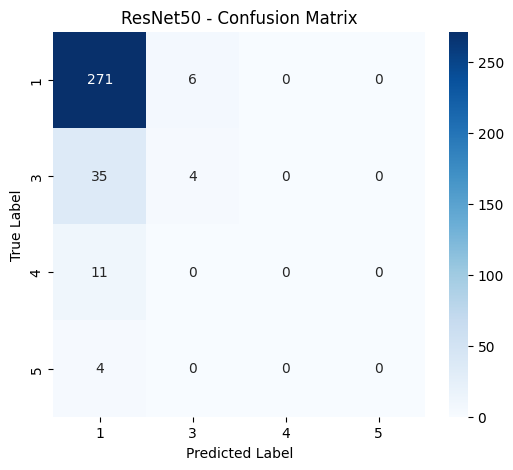

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step

 EfficientNetB0 Classification Report
              precision    recall  f1-score   support

    BIRADS 1       0.00      0.00      0.00       277
           3       0.00      0.00      0.00        39
           4       0.03      1.00      0.06        11
           5       0.00      0.00      0.00         4

    accuracy                           0.03       331
   macro avg       0.01      0.25      0.02       331
weighted avg       0.00      0.03      0.00       331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


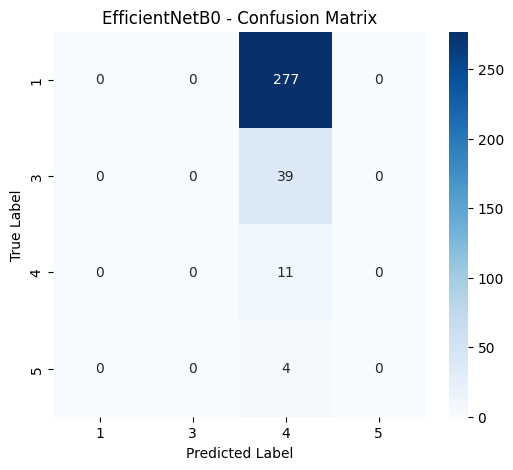

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

 MobileNetV2 Classification Report
              precision    recall  f1-score   support

    BIRADS 1       1.00      0.86      0.92       277
           3       0.53      0.21      0.30        39
           4       0.14      0.91      0.24        11
           5       0.80      1.00      0.89         4

    accuracy                           0.79       331
   macro avg       0.62      0.74      0.59       331
weighted avg       0.91      0.79      0.83       331



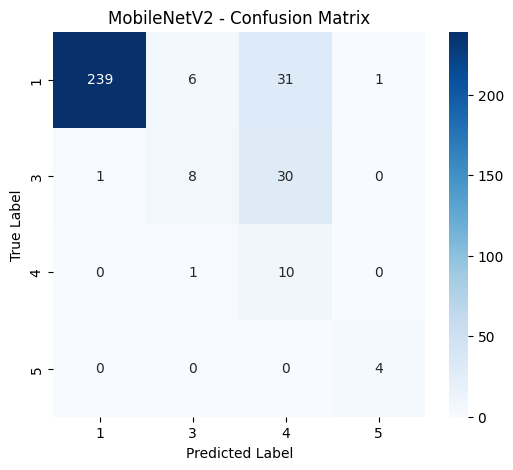

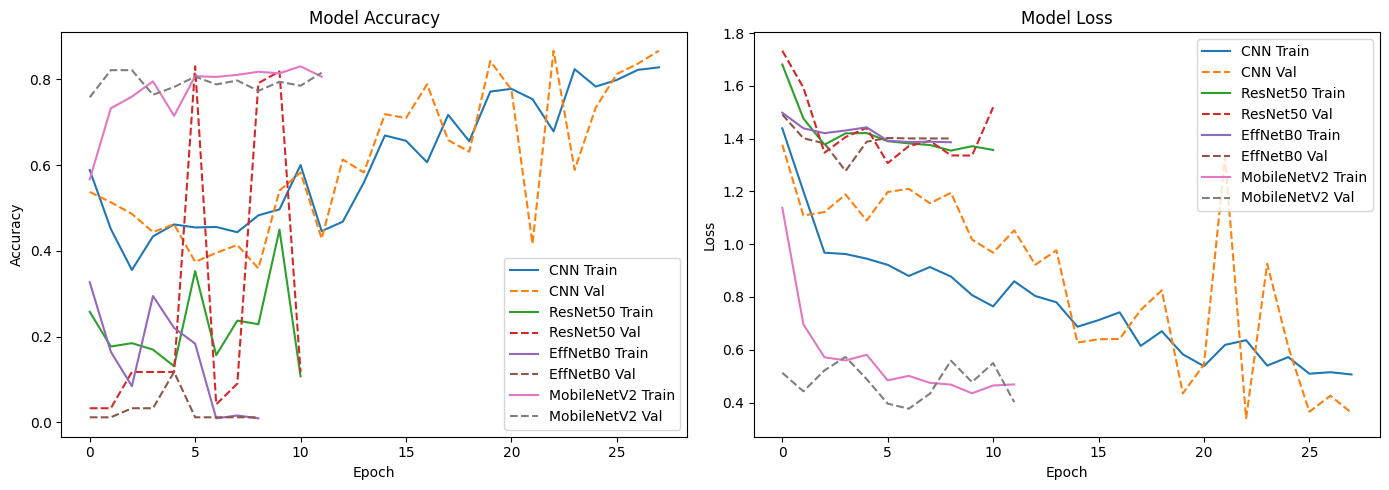

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, val_ds, name="Model"):
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=["BIRADS 1", "3", "4", "5"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["1", "3", "4", "5"], yticklabels=["1", "3", "4", "5"])
    plt.title(f"{name} - Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Accuracy/Loss plotting utility
def plot_histories(histories, names):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, names):
        plt.plot(hist.history['accuracy'], label=f'{label} Train')
        plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, names):
        plt.plot(hist.history['loss'], label=f'{label} Train')
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{label} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#  Evaluate all models
evaluate_model(cnn_model, val_ds, "CNN")
evaluate_model(resnet_model, val_ds, "ResNet50")
evaluate_model(effnet_model, val_ds, "EfficientNetB0")
evaluate_model(mobile_model, val_ds, "MobileNetV2")

#  Plot training curves
plot_histories(
    [cnn_history, resnet_history, effnet_history, mobile_history],
    ["CNN", "ResNet50", "EffNetB0", "MobileNetV2"]
)



In [82]:
model_info = {
    "CNN Baseline": (cnn_model, 'conv2d_8'),
    "ResNet50":     (resnet_model, 'resnet50'),
    "EffNetB0":     (effnet_model, 'efficientnetb0'),
    "MobileNetV2":  (mobile_model, 'mobilenetv2_1.00_224'),
}


In [83]:
for model in [cnn_model, resnet_model, effnet_model, mobile_model]:
    dummy_input = tf.random.normal((1, 224, 224, 3))
    _ = model(dummy_input)  # Ensure all models are built


# Ablation Studies

Ablation Study – Dropout Off

In [84]:
def build_cnn_ablation(dropout=False):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5) if dropout else layers.Activation('linear'),
        layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  Without dropout
cnn_no_dropout = build_cnn_ablation(dropout=False)
history_no_dropout = cnn_no_dropout.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop], class_weight=class_weights)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 379s 6s/step - accuracy: 0.5432 - loss: 42.8081 - val_accuracy: 0.0121 - val_loss: 211.3209
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 405s 7s/step - accuracy: 0.7484 - loss: 10.1158 - val_accuracy: 0.0121 - val_loss: 167.6053
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.7061 - loss: 7.8079 - val_accuracy: 0.0121 - val_loss: 422.4654
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - accuracy: 0.7032 - loss: 4.5207 - val_accuracy: 0.0121 - val_loss: 458.0958
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 448s 7s/step - accuracy: 0.6884 - loss: 1.7956 - val_accuracy: 0.0121 - val_loss: 457.9253
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.7897 - loss: 5.5065 - val_accuracy: 0.0121 - val_loss: 433.6779
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 422s 6s/step - accuracy: 0.7742 - loss: 1.3411 - val_accuracy: 0.0211 - val_loss: 264.6202


Compare Ablation Results

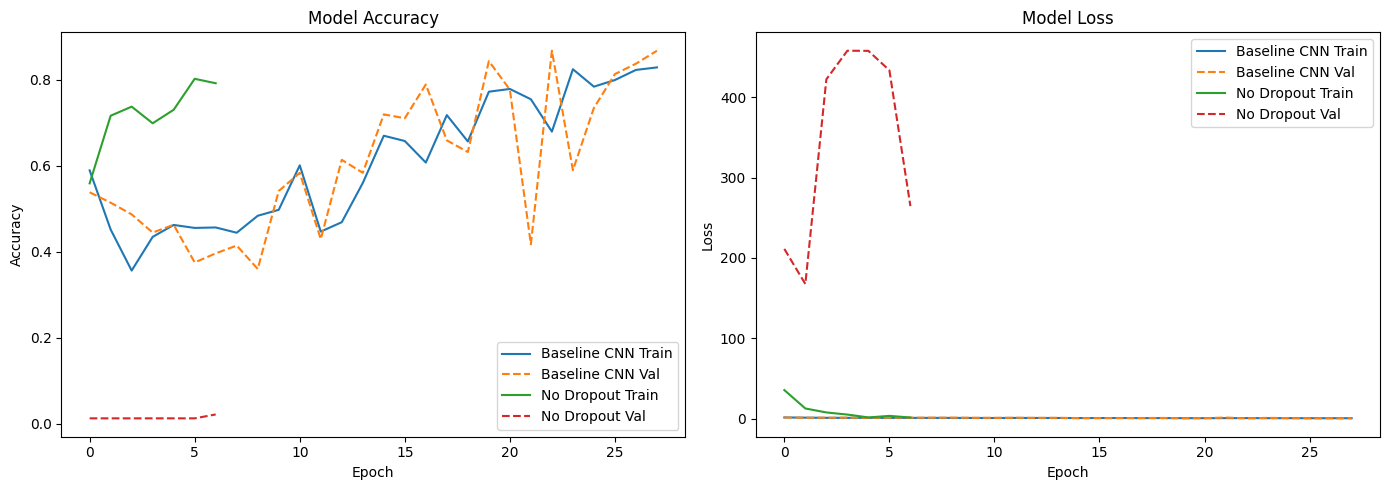

In [85]:
plot_histories([cnn_history, history_no_dropout], ["Baseline CNN", "No Dropout"])


**Error Analysis**

Show Misclassified Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


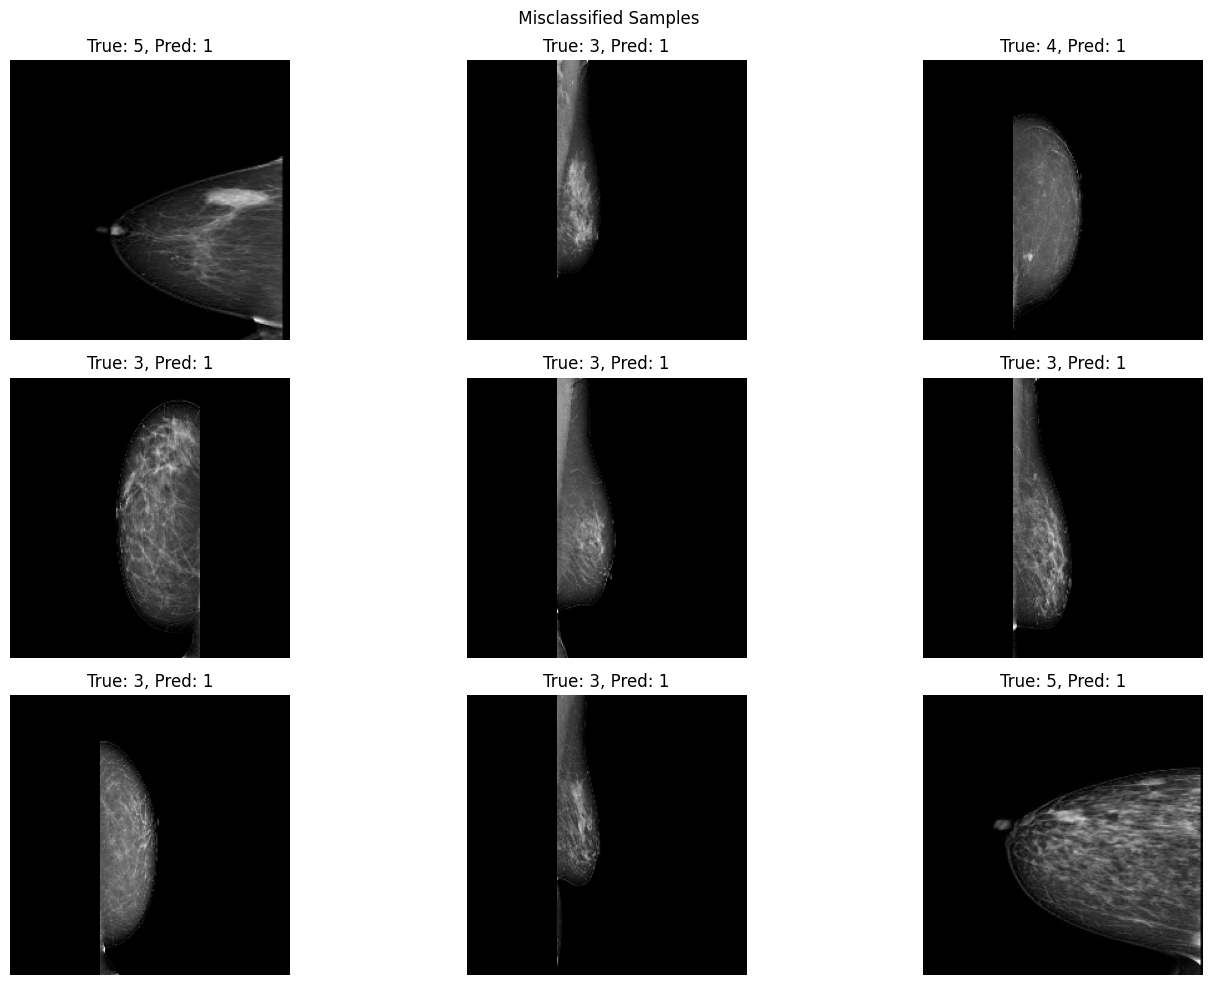

In [86]:
def show_misclassified_samples(model, val_ds, label_names=["1", "3", "4", "5"]):
    y_true, y_pred = [], []
    imgs = []

    for x_batch, y_batch in val_ds:
        preds = model.predict(x_batch)
        y_pred_batch = np.argmax(preds, axis=1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(y_pred_batch)
        imgs.extend(x_batch.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    imgs = np.array(imgs)

    mis_idx = np.where(y_true != y_pred)[0][:9]  # take first 9 mistakes

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(mis_idx):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[idx])
        plt.title(f"True: {label_names[y_true[idx]]}, Pred: {label_names[y_pred[idx]]}")
        plt.axis("off")
    plt.suptitle(" Misclassified Samples")
    plt.tight_layout()
    plt.show()

# Apply to best model
show_misclassified_samples(resnet_model, val_ds)


Accuracy & F1 Score

In [87]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def evaluate_simple(model, val_ds, name="Model"):
    y_true, y_pred = [], []
    for x, y in val_ds:
        preds = model.predict(x)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(y.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')  # macro averages across all classes
    return {"Model": name, "Accuracy": acc, "F1 Score": f1}

# Evaluate each variant
results = []
results.append(evaluate_simple(cnn_model, val_ds, "CNN Baseline"))
results.append(evaluate_simple(cnn_no_dropout, val_ds, "CNN No Dropout"))



#  Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
            Model  Accuracy  F1 Score
0    CNN Baseline  0.858006  0.596188
1  CNN No Dropout  0.012085  0.005970


In [93]:
# Install the package for Tex and then convert to PDF directly as LaTex
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null
# Provide the file path of the notebook file inside the quotations
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/EEE385L_dataset.ipynb"